Transfor learning Mango Classification: pick a pre-trained model

### Import

In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#copy
!cp '/content/drive/MyDrive/TFkeras/mango.zip' /content

In [27]:
!unzip /content/mango.zip -d /content/ #unzip

Archive:  /content/mango.zip
replace /content/mango/dev.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Create Generator

In [28]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=tf.keras.applications.xception.preprocess_input
    )

In [29]:
testgenerator = ImageDataGenerator(rescale = 1./255,
    preprocessing_function=tf.keras.applications.xception.preprocess_input
    )

In [30]:
target_size = [256, 256]
batch_size = 32

### mango 分A B C 等級
載入mango數據集 從 csv檔

In [31]:
train_dir = '/content/mango/Train/'
test_dir = '/content/mango/Dev/'
dftrain = pd.read_csv(r'/content/mango/train.csv')
dftest = pd.read_csv(r'/content/mango/dev.csv')
print(dftrain.shape, dftest.shape)
print(dftrain.head())

(5600, 2) (800, 2)
    image_id label
0  00002.jpg     C
1  00003.jpg     C
2  00004.jpg     B
3  00005.jpg     A
4  00007.jpg     A


In [32]:
train_gen = generator.flow_from_dataframe(dataframe=dftrain, directory=train_dir, x_col="image_id", y_col="label",
                                          class_mode="categorical",
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          seed=101,
                                          subset='training')

val_gen = generator.flow_from_dataframe(dataframe=dftrain, directory=train_dir, x_col="image_id", y_col="label",
                                         class_mode="categorical",
                                         target_size=target_size,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=101,
                                         subset='validation')

test_gen = testgenerator.flow_from_dataframe(dataframe=dftest, directory=test_dir, x_col="image_id", y_col="label",
                                         class_mode="categorical",
                                         target_size=target_size,
                                         batch_size=1,
                                         shuffle=False,
                                         )

Found 4480 validated image filenames belonging to 3 classes.
Found 1120 validated image filenames belonging to 3 classes.
Found 800 validated image filenames belonging to 3 classes.


In [ ]:
print(train_gen.samples, val_gen.samples, test_gen.samples)

4480 1120 800


In [42]:
print(train_gen.class_indices)

{'A': 0, 'B': 1, 'C': 2}


In [43]:
# initializing label list and feeding in classes/indices
labels = [None]*len(train_gen.class_indices)

for item, indice in train_gen.class_indices.items():
    labels[indice] = item

In [44]:
labels

['A', 'B', 'C']

### 訓練Model

In [45]:
# 創建模型(不包含全連接層和預訓練權重)，最後一層卷積加上GlobalAveragePooling
base_model = tf.keras.applications.xception.Xception(include_top=False, #include_top是指全連階層
                                               weights='imagenet',
                                               pooling='avg',
                                               input_shape=target_size+[3]) # [128, 128, 3]
# 將剛創建的Resnet模型接上3層全連接層，並且最後一層使用Softmax輸出
model_1 = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,140,651
Trainable params: 21,086,123
Non-trainable params: 54,528
_________________________________________________________________


In [33]:
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TFkeras/Xception.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001) #ReduceLROnPlateau學習率下降（步伐走變慢），以loss監測，舉例loss的變化沒有超過10-4次方就當不變
# 設定停止訓練的條件(當Accuracy超過5迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)

In [34]:
adam = optimizers.Adam(learning_rate=1e-3)
model_1.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [ ]:
history = model_1.fit_generator(generator=train_gen,
                        steps_per_epoch = train_gen.samples//batch_size,
                        validation_data=val_gen,
                        validation_steps= val_gen.samples//batch_size,
                        epochs=30,
                        callbacks=[rlr, model_mckp,model_esp]) #callback裡面變越來越多東西

<ipython-input-18-51717535ee5c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_1.fit_generator(generator=train_gen,


Epoch 1/30
140/140 [==============================] - 206s 1s/step - loss: 0.7193 - categorical_accuracy: 0.6754 - val_loss: 1.2649 - val_categorical_accuracy: 0.3723 - lr: 0.0010
Epoch 2/30
140/140 [==============================] - 169s 1s/step - loss: 0.6097 - categorical_accuracy: 0.7355 - val_loss: 5.0165 - val_categorical_accuracy: 0.3045 - lr: 0.0010
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.5506 - categorical_accuracy: 0.7607
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
140/140 [==============================] - 152s 1s/step - loss: 0.5506 - categorical_accuracy: 0.7607 - val_loss: 1.5168 - val_categorical_accuracy: 0.3304 - lr: 0.0010
Epoch 4/30
140/140 [==============================] - 162s 1s/step - loss: 0.4809 - categorical_accuracy: 0.7893 - val_loss: 1.1451 - val_categorical_accuracy: 0.4786 - lr: 2.0000e-04
Epoch 5/30
140/140 [==============================] - 161s 1s/step - loss: 0.4585 - categorical_accura

In [ ]:
## 預測

In [46]:
#混淆矩陣（confusion matrix）
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, data_dir, lenlab, size, image_size):
    prediction = []
    predictions = []
    true_y = []
    predictprob = np.empty([size, lenlab])

    ix = 0
    for x,y in test_gen: # testgenerator.flow_from_directory(data_dir, batch_size=1, target_size=image_size, shuffle=False):
        prediction =  model.predict(x) # (1,2)
        predictprob[ix,:] = prediction
        # decoding one-hot
        prediction = np.argmax(prediction, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
        ix+=1

    matrix = confusion_matrix(true_y, predictions)

    return predictprob, matrix

In [50]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/Xception.h5')
pred_xception, conf_matrix_xception = get_conf_matrix(model, test_dir, len(labels), test_gen.samples, target_size)
print(conf_matrix_xception[:,:])
del model
K.clear_session()

1/1 [==============================] - 0s 42ms/step
[[198  42   3]
 [ 39 240  14]
 [  1  37 226]]


In [51]:
#畫圖
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.81481481 0.17283951 0.01234568]
 [0.1331058  0.81911263 0.04778157]
 [0.00378788 0.14015152 0.85606061]]


0.5475

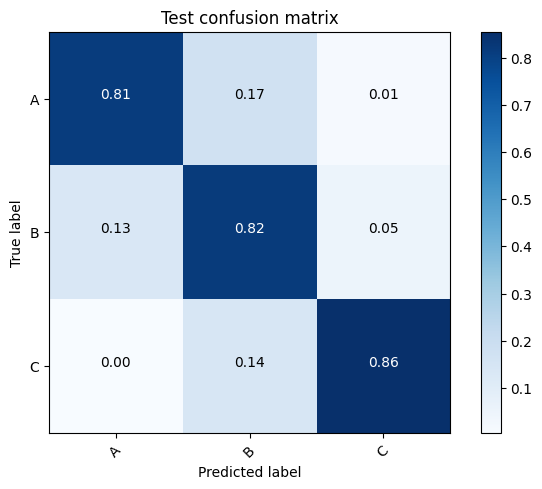

In [53]:
plot_confusion_matrix(conf_matrix_xception, labels, title = "Test confusion matrix")
sum([conf_matrix_xception[i, i] for i in range(2)])/test_gen.samples